# 2. Embedding

In [1]:
import json
import utils
import faiss

import warnings
warnings.filterwarnings('ignore')

import numpy as np

from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sentence_transformers import SentenceTransformer

In [2]:
# reading docs
documents = json.load(open('outputs/preprocessed.json'))
documents_wo_sw = json.load(open('outputs/preprocessed_wo_stopwords.json'))

## 2.1 TF-IDF

In [3]:
# building word embedding based on tf-idf
vectorizer = TfidfVectorizer(norm='l2')
tfidf_transformer = vectorizer.fit(documents.values())
tfidf = tfidf_transformer.transform(documents.values()).toarray()
tfidf.shape

(1239, 13171)

In [4]:
# building word embedding based on tf-idf
vectorizer = TfidfVectorizer(norm='l2')
tfidf_transformer_wo_sw = vectorizer.fit(documents_wo_sw.values())
tfidf_wo_sw = tfidf_transformer_wo_sw.transform(documents_wo_sw.values()).toarray()
tfidf_wo_sw.shape

(1239, 13141)

## 2.2 BERTsentece

In [5]:
# changing the max words of the model (default == 512)
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')
model.max_seq_length

512

In [6]:
# building word embedding based on BERT model
bert = model.encode(list(documents.values()))
bert_wo_sw = model.encode(list(documents_wo_sw.values()))
bert.shape, bert_wo_sw.shape

((1239, 768), (1239, 768))

## 2.3 Queries

In [7]:
# reading queries and rel. docs
queries = json.load(open('outputs/queries.json'))
queries_wo_sw = json.load(open('outputs/queries_wo_stopwords.json'))
rel_docs = json.load(open('outputs/relevant_docs.json'))

In [8]:
# converting the queries
queries = utils.convert_queries(queries, model, tfidf_transformer)
queries_wo_sw = utils.convert_queries(queries_wo_sw, model, tfidf_transformer_wo_sw)

# 3. Index

In [9]:
# number of documents to be returned in queries
k = int(np.mean([len(r) for r in rel_docs.values()]))

# collection and queries size
collection_size = len(documents.values())
n_queries = len(queries.items())

# threshold for reciprocal rank
threshold = 5

In [10]:
# checking
k, collection_size, n_queries

(48, 1239, 100)

## 3.1 Documents without preprocessing

### 3.1.1 Flat

#### 3.1.1.1 Bert

In [11]:
# normalizing the embeddings
bert_normalized = bert.copy()
faiss.normalize_L2(bert_normalized)

In [12]:
# builds the index
idx_flat_bert = utils.index_flat(bert_normalized)

In [13]:
# doing the queries
flat_bert_results = utils.search(idx_flat_bert, k, 'embedding', queries, rel_docs, collection_size, threshold)

In [14]:
# computing MRR
flat_bert_mrr = utils.mean_reciprocal_rank(flat_bert_results)
flat_bert_mrr

1.32

#### 3.1.1.2 TF-IDF

In [15]:
# builds the index
idx_flat_tfidf = utils.index_flat(tfidf.astype(np.float32))

In [16]:
# doing the queries
flat_tfidf_results = utils.search(idx_flat_tfidf, k, 'tf-idf', queries, rel_docs, collection_size, threshold)

In [17]:
# computing MRR
flat_tfidf_mrr = utils.mean_reciprocal_rank(flat_tfidf_results)
flat_tfidf_mrr

1.35

### 3.1.2 IVFFlat

#### 3.1.2.1 Bert

In [18]:
nlist = 10
idx_ivfflat_bert = utils.index_ivfflat(bert_normalized, nlist)
idx_ivfflat_bert.is_trained, idx_ivfflat_bert.ntotal

(True, 1239)

In [19]:
# doing the queries
ivfflat_bert_results = utils.search(idx_ivfflat_bert, k, 'embedding', queries, 
                                    rel_docs, collection_size, threshold)

In [20]:
# computing MRR
ivfflat_bert_mrr = utils.mean_reciprocal_rank(ivfflat_bert_results)
ivfflat_bert_mrr

1.11

#### 3.1.2.2 TF-IDF

In [21]:
# builds the index
idx_flat_tfidf = utils.index_ivfflat(tfidf.astype(np.float32), nlist)

In [22]:
# doind the queries
ivfflat_tfidf_results = utils.search(idx_flat_tfidf, k, 'tf-idf', queries, 
                                     rel_docs, collection_size, threshold)

In [23]:
# computing MRR
ivfflat_tfidf_mrr = utils.mean_reciprocal_rank(ivfflat_tfidf_results)
ivfflat_tfidf_mrr

1.2

## 3.2 Documents without stopwords

### 3.2.1 Flat

#### 3.2.1.1 Bert

In [24]:
# normalizing the embeddings
bert_normalized_wo_sw = bert_wo_sw.copy()
faiss.normalize_L2(bert_normalized_wo_sw)

In [25]:
# builds the index
idx_flat_bert_wo_sw = utils.index_flat(bert_normalized_wo_sw)

In [26]:
# doing the queries
flat_bert_results_wo_sw = utils.search(idx_flat_bert_wo_sw, k, 'embedding', 
                                       queries_wo_sw, rel_docs, collection_size, 
                                       threshold)

In [27]:
# computing MRR
flat_bert_mrr_wo_sw = utils.mean_reciprocal_rank(flat_bert_results_wo_sw)
flat_bert_mrr_wo_sw

1.35

#### 3.2.1.2 TF-IDF

In [28]:
# builds the index
idx_flat_tfidf_wo_sw = utils.index_flat(tfidf_wo_sw.astype(np.float32))

In [29]:
# doing the queries
flat_tfidf_results_wo_sw = utils.search(idx_flat_tfidf_wo_sw, k, 'tf-idf', 
                                        queries_wo_sw, rel_docs, collection_size, 
                                        threshold)

In [30]:
# computing MRR
flat_tfidf_mrr_wo_sw = utils.mean_reciprocal_rank(flat_tfidf_results_wo_sw)
flat_tfidf_mrr_wo_sw

1.42

### 3.2.2 IVFFlat

#### 3.2.2.1 Bert

In [31]:
idx_ivfflat_bert_wo_sw = utils.index_ivfflat(bert_normalized_wo_sw, nlist)
idx_ivfflat_bert_wo_sw.is_trained, idx_ivfflat_bert_wo_sw.ntotal

(True, 1239)

In [32]:
# doing the queries
ivfflat_bert_results_wo_sw = utils.search(idx_ivfflat_bert_wo_sw, k, 'embedding', 
                                          queries_wo_sw, rel_docs, collection_size, 
                                          threshold)

In [33]:
# computing MRR
ivfflat_bert_mrr_wo_sw = utils.mean_reciprocal_rank(ivfflat_bert_results_wo_sw)
ivfflat_bert_mrr_wo_sw

1.21

#### 3.2.2.2 TF-IDF

In [34]:
# builds the index
idx_flat_tfidf_wo_sw = utils.index_ivfflat(tfidf_wo_sw.astype(np.float32), nlist)

In [35]:
# doind the queries
ivfflat_tfidf_results_wo_sw = utils.search(idx_flat_tfidf_wo_sw, k, 'tf-idf', 
                                           queries_wo_sw, rel_docs, collection_size, 
                                           threshold)

In [36]:
# computing MRR
ivfflat_tfidf_mrr_wo_sw = utils.mean_reciprocal_rank(ivfflat_tfidf_results_wo_sw)
ivfflat_tfidf_mrr_wo_sw

1.15

# 4. Evaluate

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='white')

In [38]:
# recall
recall = np.arange(0, 1.1, 0.1)

## 4.1 Precision

In [39]:
# getting the precision_recall
p_results = {
    'Flat - sentenceBERT': [r['precision'] for r in flat_bert_results.values()],
    'Flat - TF-IDF': [r['precision'] for r in flat_tfidf_results.values()],
    'IVFFlat - sentenceBERT': [r['precision'] for r in ivfflat_bert_results.values()],
    'IVFFlat - TF-IDF': [r['precision'] for r in ivfflat_tfidf_results.values()],
}

p_results_wo_sw = {
    'Flat - sentenceBERT': [r['precision'] for r in flat_bert_results_wo_sw.values()],
    'Flat - TF-IDF': [r['precision'] for r in flat_tfidf_results_wo_sw.values()],
    'IVFFlat - sentenceBERT': [r['precision'] for r in ivfflat_bert_results_wo_sw.values()],
    'IVFFlat - TF-IDF': [r['precision'] for r in ivfflat_tfidf_results_wo_sw.values()],
}

# transforming into dataframe
p_results = pd.melt(pd.DataFrame(p_results))
p_results_wo_sw = pd.melt(pd.DataFrame(p_results_wo_sw))

# labeling
p_results['Preprocessing'] = 'no preprocessing'
p_results_wo_sw['Preprocessing'] = 'no stopwords'

# join
p_results = pd.concat([p_results, p_results_wo_sw]).reset_index(drop=True)

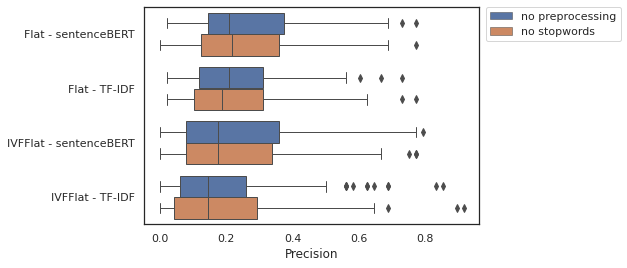

In [40]:
# plotting the results
plt.figure(figsize=(6, 4))
sns.boxplot(y='variable', x='value', orient='h', hue='Preprocessing', linewidth=1, data=p_results)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Precision'), plt.ylabel('')
plt.show()

## 4.2 Recall

In [41]:
# getting the precision_recall
r_results = {
    'Flat - sentenceBERT': [r['recall'] for r in flat_bert_results.values()],
    'Flat - TF-IDF': [r['recall'] for r in flat_tfidf_results.values()],
    'IVFFlat - sentenceBERT': [r['recall'] for r in ivfflat_bert_results.values()],
    'IVFFlat - TF-IDF': [r['recall'] for r in ivfflat_tfidf_results.values()],
}

r_results_wo_sw = {
    'Flat - sentenceBERT': [r['recall'] for r in flat_bert_results_wo_sw.values()],
    'Flat - TF-IDF': [r['recall'] for r in flat_tfidf_results_wo_sw.values()],
    'IVFFlat - sentenceBERT': [r['recall'] for r in ivfflat_bert_results_wo_sw.values()],
    'IVFFlat - TF-IDF': [r['recall'] for r in ivfflat_tfidf_results_wo_sw.values()],
}

# transforming into dataframe
r_results = pd.melt(pd.DataFrame(r_results))
r_results_wo_sw = pd.melt(pd.DataFrame(r_results_wo_sw))

# labeling
r_results['Preprocessing'] = 'no preprocessing'
r_results_wo_sw['Preprocessing'] = 'no stopwords'

# join
r_results = pd.concat([r_results, r_results_wo_sw]).reset_index(drop=True)

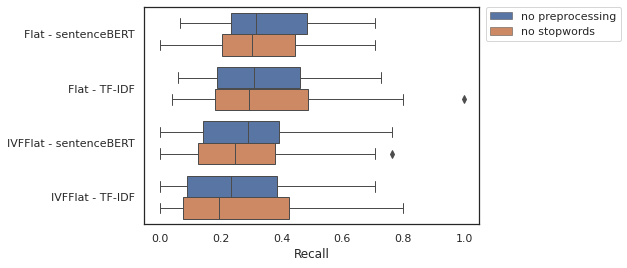

In [42]:
# plotting the results
plt.figure(figsize=(6, 4))
sns.boxplot(y='variable', x='value', orient='h', hue='Preprocessing', linewidth=1, data=r_results)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Recall'), plt.ylabel('')
plt.show()

## 4.3 The 11 Standard Recall Levels

In [43]:
# getting the precision_recall
p_r_results = {
    'Flat - sentenceBERT': np.mean([r['precision_recall'][:, 1] for r in flat_bert_results.values()], axis=0),
    'Flat - TF-IDF': np.mean([r['precision_recall'][:, 1] for r in flat_tfidf_results.values()], axis=0),
    'IVFFlat - sentenceBERT': np.mean([r['precision_recall'][:, 1] for r in ivfflat_bert_results.values()], axis=0),
    'IVFFlat - TF-IDF': np.mean([r['precision_recall'][:, 1] for r in ivfflat_tfidf_results.values()], axis=0),
}

p_r_results_wo_sw = {
    'Flat - sentenceBERT': np.mean([r['precision_recall'][:, 1] for r in flat_bert_results_wo_sw.values()], axis=0),
    'Flat - TF-IDF': np.mean([r['precision_recall'][:, 1] for r in flat_tfidf_results_wo_sw.values()], axis=0),
    'IVFFlat - sentenceBERT': np.mean([r['precision_recall'][:, 1] for r in ivfflat_bert_results_wo_sw.values()], axis=0),
    'IVFFlat - TF-IDF': np.mean([r['precision_recall'][:, 1] for r in ivfflat_tfidf_results_wo_sw.values()], axis=0),
}

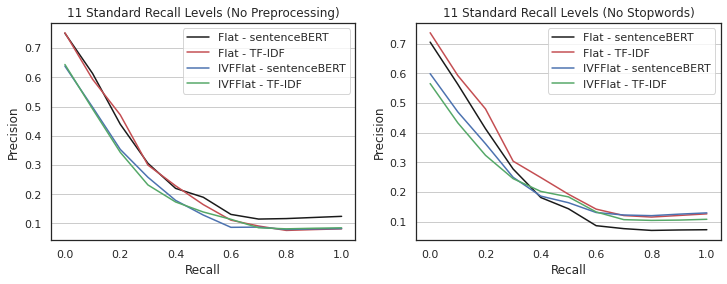

In [44]:
# Precision-Recall Curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
utils.plot_recall_levels(p_r_results, 'No Preprocessing')

plt.subplot(1, 2, 2)
utils.plot_recall_levels(p_r_results_wo_sw, 'No Stopwords')

## 4.4 P@5

In [45]:
# getting the p@5 and p@10
p5_results = {
    'Flat - sentenceBERT': [r['p@5'] for r in flat_bert_results.values()],
    'Flat - TF-IDF': [r['p@5'] for r in flat_tfidf_results.values()],
    'IVFFlat - sentenceBERT': [r['p@5'] for r in ivfflat_bert_results.values()],
    'IVFFlat - TF-IDF': [r['p@5'] for r in ivfflat_tfidf_results.values()],
}

p5_results_wo_sw = {
    'Flat - sentenceBERT': [r['p@5'] for r in flat_bert_results_wo_sw.values()],
    'Flat - TF-IDF': [r['p@5'] for r in flat_tfidf_results_wo_sw.values()],
    'IVFFlat - sentenceBERT': [r['p@5'] for r in ivfflat_bert_results_wo_sw.values()],
    'IVFFlat - TF-IDF': [r['p@5'] for r in ivfflat_tfidf_results_wo_sw.values()],
}

# transforming into dataframe
p5_results = pd.melt(pd.DataFrame(p5_results))
p5_results_wo_sw = pd.melt(pd.DataFrame(p5_results_wo_sw))

# labeling
p5_results['Preprocessing'] = 'no preprocessing'
p5_results_wo_sw['Preprocessing'] = 'no stopwords'

# join
p5_results = pd.concat([p5_results, p5_results_wo_sw]).reset_index(drop=True)

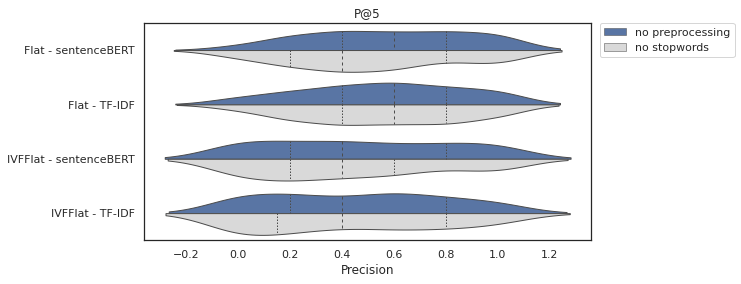

In [46]:
# plotting the results
utils.p_at(p5_results, 'P@5')

## 4.5 P@10

In [47]:
# getting the p@5 and p@10
p10_results = {
    'Flat - sentenceBERT': [r['p@10'] for r in flat_bert_results.values()],
    'Flat - TF-IDF': [r['p@10'] for r in flat_tfidf_results.values()],
    'IVFFlat - sentenceBERT': [r['p@10'] for r in ivfflat_bert_results.values()],
    'IVFFlat - TF-IDF': [r['p@10'] for r in ivfflat_tfidf_results.values()],
}

p10_results_wo_sw = {
    'Flat - sentenceBERT': [r['p@10'] for r in flat_bert_results_wo_sw.values()],
    'Flat - TF-IDF': [r['p@10'] for r in flat_tfidf_results_wo_sw.values()],
    'IVFFlat - sentenceBERT': [r['p@10'] for r in ivfflat_bert_results_wo_sw.values()],
    'IVFFlat - TF-IDF': [r['p@10'] for r in ivfflat_tfidf_results_wo_sw.values()],
}

# transforming into dataframe
p10_results = pd.melt(pd.DataFrame(p10_results))
p10_results_wo_sw = pd.melt(pd.DataFrame(p10_results_wo_sw))

# labeling
p10_results['Preprocessing'] = 'no preprocessing'
p10_results_wo_sw['Preprocessing'] = 'no stopwords'

# join
p10_results = pd.concat([p10_results, p10_results_wo_sw]).reset_index(drop=True)

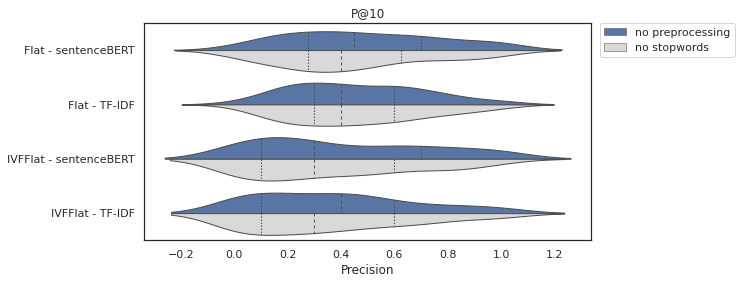

In [48]:
# plotting the results
utils.p_at(p10_results, 'P@10')

## 4.6 MRR(Q)

In [49]:
# getting the results
mrr_results = {
    f'Flat - sentenceBERT [MRR: {flat_bert_mrr}]': [r['reciprocal_rank'] for r in flat_bert_results.values()],
    f'Flat - TF-IDF [MRR: {flat_tfidf_mrr}]': [r['reciprocal_rank'] for r in flat_tfidf_results.values()],
    f'IVFFlat - sentenceBERT [MRR: {ivfflat_bert_mrr}]': [r['reciprocal_rank'] for r in ivfflat_bert_results.values()],
    f'IVFFlat - TF-IDF [MRR: {ivfflat_tfidf_mrr}]': [r['reciprocal_rank'] for r in ivfflat_tfidf_results.values()],
}

mrr_results_wo_sw = {
    f'Flat - sentenceBERT [MRR: {flat_bert_mrr_wo_sw}]': [r['reciprocal_rank'] for r in flat_bert_results_wo_sw.values()],
    f'Flat - TF-IDF [MRR: {flat_tfidf_mrr_wo_sw}]': [r['reciprocal_rank'] for r in flat_tfidf_results_wo_sw.values()],
    f'IVFFlat - sentenceBERT [MRR: {ivfflat_bert_mrr_wo_sw}]': [r['reciprocal_rank'] for r in ivfflat_bert_results_wo_sw.values()],
    f'IVFFlat - TF-IDF [MRR: {ivfflat_tfidf_mrr_wo_sw}]': [r['reciprocal_rank'] for r in ivfflat_tfidf_results_wo_sw.values()],
}

# transforming into datafra
mrr_results = pd.melt(pd.DataFrame(mrr_results), var_name='Type')
mrr_results_wo_sw = pd.melt(pd.DataFrame(mrr_results_wo_sw), var_name='Type')

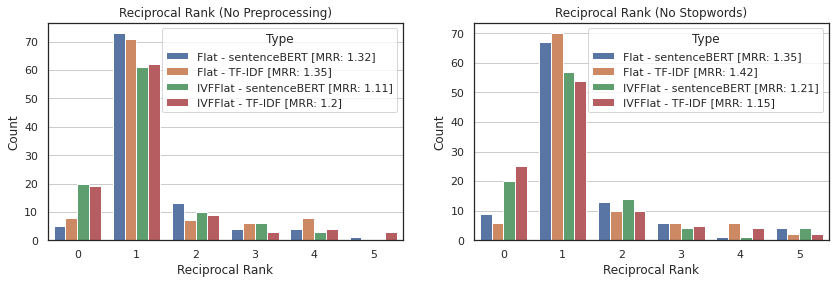

In [50]:
# plotting the results
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
utils.mrr_plot(mrr_results, 'No Preprocessing')

plt.subplot(1, 2, 2)
utils.mrr_plot(mrr_results_wo_sw, 'No Stopwords')

## 4.6 Histogram

In [51]:
p1 = []
p2 = []
for k, _ in ivfflat_bert_results.items():
    p1.append(ivfflat_tfidf_results[k]['precision'])
    p2.append(ivfflat_bert_results[k]['precision'])

In [52]:
p1 = np.array(p1)
p2 = np.array(p2)

In [53]:
import matplotlib.pyplot as plt

In [54]:
p = p1 - p2
p[:10]

array([ 0.        ,  0.0625    , -0.25      ,  0.02083333,  0.25      ,
       -0.02083333, -0.1875    , -0.0625    , -0.08333333, -0.02083333])

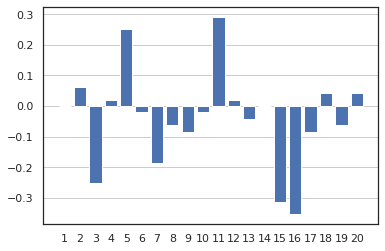

In [55]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, 21), p[:20])
ax.set_xticks([i for i in np.arange(1, 21)])
plt.grid(axis='y')
plt.show()